<a href="https://colab.research.google.com/github/GRACOPORDEUS/atividades_mestrado/blob/main/1107106_220511_lista2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 1ª Questão

"que tipo de pessoa tem mais probabilidade de sobreviver?"

### data manipulation

#### import from kaggle

In [1]:
!pip install kaggle

In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle competitions download -c titanic --force

  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 21.2MB/s]


In [6]:
! unzip titanic.zip

Archive:  titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


#### data preprocessing

In [9]:
titanic_train = pd.read_csv("train.csv")
titanic_test = pd.read_csv("test.csv")

Train

In [10]:
titanic_train.drop(['Name','Ticket','Cabin'],axis=1,inplace=True)
y = titanic_train.loc[:, 'Survived'].values

sex = pd.get_dummies(titanic_train['Sex'],drop_first=True)
embark = pd.get_dummies(titanic_train['Embarked'],drop_first=True)

titanic_train = pd.concat([titanic_train,sex,embark],axis=1)

titanic_train.drop(['Sex','Embarked'],axis=1,inplace=True)

titanic_train.fillna(titanic_train.mean(),inplace=True)

train_columns = titanic_train.columns
titanic_train = pd.DataFrame(StandardScaler().fit_transform(titanic_train))
titanic_train.columns  = train_columns

features = titanic_train.iloc[:,2:].columns.tolist()
target   = titanic_train.loc[:, 'Survived'].name

X = titanic_train.iloc[:,2:].values

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [12]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((712, 8), (712,), (179, 8), (179,))

Test

In [13]:
titanic_test.drop(['Name','Ticket','Cabin'],axis=1,inplace=True)

sex = pd.get_dummies(titanic_test['Sex'],drop_first=True)
embark = pd.get_dummies(titanic_test['Embarked'],drop_first=True)

titanic_test = pd.concat([titanic_test,sex,embark],axis=1)

titanic_test.drop(['Sex','Embarked'],axis=1,inplace=True)

titanic_test.fillna(titanic_test.mean(),inplace=True)

test_columns  = titanic_test.columns
titanic_test = pd.DataFrame(StandardScaler().fit_transform(titanic_test))
titanic_test.columns  = test_columns

In [14]:
test = titanic_test.iloc[:,1:].values

In [15]:
test.shape

(418, 8)

### Network

In [16]:
class dataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(x).float()
        self.y = torch.from_numpy(y)
        self.n_sample = x.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.n_sample

In [17]:
train_dataset = dataset(X_train, y_train)
test_dataset = dataset(X_test, y_test)

In [18]:
# datasset parameters
input_size = X_train.shape[1]
batch_size = X_train.shape[0]
num_classes = 2

In [19]:
train_loader = DataLoader(
    dataset = train_dataset,
    batch_size = batch_size,
    shuffle = True)

test_loader = DataLoader(
    dataset = test_dataset,
    batch_size = batch_size,
    shuffle = True)

In [92]:
class NN(nn.Module):
  def __init__(self, input_size, num_classes, tx_dropout):
    super(NN, self).__init__()
    self.fc1 = nn.Linear(input_size, 30)
    self.fc2 = nn.Linear(30, 15)
    self.fc3 = nn.Linear(15, num_classes)
    
    self.dropout = nn.Dropout(tx_dropout)

    self.bn1 = nn.BatchNorm1d(30)
    self.bn2 = nn.BatchNorm1d(15)
  
  def forward(self, x):
    x = F.relu(self.bn1(self.fc1(x)))
    x = self.dropout(F.relu(self.bn2(self.fc2(x))))
    x = torch.sigmoid(self.fc3(x))
    return x

In [21]:
print(NN(input_size, num_classes, tx_dropout= 0))

NN(
  (fc1): Linear(in_features=8, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=2, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (bn1): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [118]:
# Check accuracy on training & test to see how good our model
def valdation_metrics(loader, losses, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            x = x.reshape(x.shape[0], -1)

            outputs = model(x)
            values, predictions = torch.max(outputs, 1)
            num_samples += predictions.size(0)
            
            # accuracy
            y_real = y.detach().numpy()
            y_pred = predictions.detach().numpy()
            accuracy = accuracy_score(y_real, y_pred)

            # validation losses
            loss = criterion(outputs, y)
            losses += loss.item() 
            losses = (losses/num_samples)

    model.train()

    return accuracy, losses

In [98]:
# ploting evaluations
def network_plots(train, test, metric):
    fig, ax = plt.subplots(figsize=(8,5))

    ax.plot(train)
    ax.plot(test)

    ax.legend(('Train', 'Test'), loc="best")
    plt.show()
    print(f"The {metric} in train was {round(train[-1],2)} and in test was {round(test[-1],2)}.")

In [126]:
# hiperparameters
num_epochs = 200
learning_rate = 0.001
tx_dropout = 0.0

# Initialize network
model = NN(
    input_size=input_size, 
    num_classes=num_classes, 
    tx_dropout=tx_dropout
    ).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train Network
plot_train_losses = []
plot_test_losses = []
plot_train_accuracy = []
plot_test_accuracy = []

for epoch in tqdm(range(num_epochs)):
    train_losses = 0.0
    test_losses = 0.0
    
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)
        # Get to correct shape
        data = data.reshape(data.shape[0], -1)
        # forward
        outputs = model(data)
        loss = criterion(outputs, targets)
        # backward
        optimizer.zero_grad()
        loss.backward()
        # gradient descent or adam step
        optimizer.step()

    # metrics
    train_metric = valdation_metrics(train_loader, train_losses, model)
    test_metric = valdation_metrics(test_loader, test_losses, model)

    # cumulative losses
    plot_train_losses.append(train_metric[1])
    plot_test_losses.append(test_metric[1])

    # cumulative accuracy
    train_accuracy = (train_metric[0]*100).item()
    test_accuracy = (test_metric[0]*100).item()
    plot_train_accuracy.append(train_accuracy)
    plot_test_accuracy.append(test_accuracy)

100%|██████████| 200/200 [00:04<00:00, 44.25it/s]


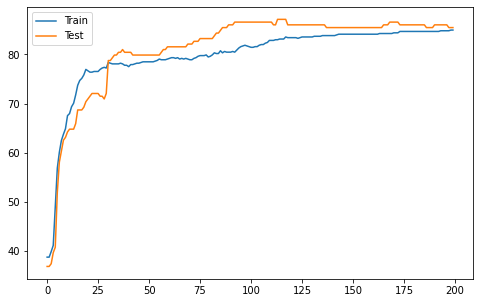

The Accuracy in train was 84.97 and in test was 85.47.


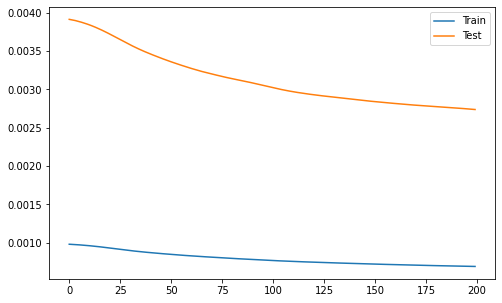

The Losses in train was 0.0 and in test was 0.0.


In [129]:
network_plots(plot_train_accuracy, plot_test_accuracy, 'Accuracy')
network_plots(plot_train_losses, plot_test_losses, 'Losses')

0.8547486033519553


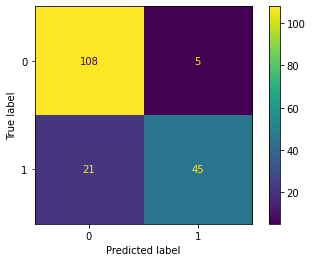

In [130]:
model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device=device)
        y = y.to(device=device)
        x = x.reshape(x.shape[0], -1)
        outputs = model(x)
        values, predictions = torch.max(outputs, 1)
model.train()

conf_matrix = confusion_matrix(
    y_true = y,
    y_pred = predictions
    )
labels = np.unique(y)

print(accuracy_score(y, predictions))


plot_cm = ConfusionMatrixDisplay(
    confusion_matrix = conf_matrix,
    display_labels = labels
    ) \
    .plot()

plt.show()

### Submission

In [131]:
class submission(Dataset):
    def __init__(self, x):
        self.x = torch.from_numpy(x).float()
        self.n_sample = x.shape[0]

    def __getitem__(self, index):
        return self.x[index]

    def __len__(self):
        return self.n_sample

sub_dataset = submission(test)
sub_loader = DataLoader(
    dataset = sub_dataset,
    batch_size = test.shape[0],
    shuffle=True)

model.eval()
with torch.no_grad():
    for x in sub_loader:
        x = x.to(device=device)
        x = x.reshape(x.shape[0], -1)
        test_result = model(x)
model.train()

values, labels = torch.max(test_result, 1)
survived = labels.data.numpy()

df_sub = pd.read_csv("gender_submission.csv")
submission = pd.DataFrame({'PassengerId': df_sub['PassengerId'], 'Survived': survived})
submission.to_csv('submission.csv', index=False)
! kaggle competitions submit -c titanic -f submission.csv -m "No mensage."

100% 2.77k/2.77k [00:02<00:00, 1.18kB/s]
Successfully submitted to Titanic - Machine Learning from Disaster

Score: 0.56220



# 2ª Questão

In [3]:
class NN(nn.Module):
    def __init__(self, input_size, num_classes, tx_dropout):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, 50)
        self.fc3 = nn.Linear(50, num_classes)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc3(x)
        return x

In [4]:
class CNN(nn.Module):
    def __init__(self, in_channel, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels = in_channel,
            out_channels = 8,
            kernel_size = (3,3),
            stride = (1,1),
            padding = (1,1)
        )
        self.pool = nn.MaxPool2d(
            kernel_size = (2,2),
            stride = (2,2),
        )
        self.conv2 = nn.Conv2d(
            in_channels = 8,
            out_channels = 16,
            kernel_size = (3,3),
            stride = (1,1),
            padding = (1,1)
        )
        self.fc1 = nn.Linear(16*7*7, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        return x

In [15]:
# dataset parameters
in_channel = 1
input_size = 784
num_classes = 10
batch_size = 64

In [6]:
train_dataset = datasets.MNIST(root="dataset/", train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root="dataset/", train=False, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [10]:
# Check accuracy on training & test to see how good our model
def valdation_metrics(loader, losses, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            outputs = model(x)
            values, predictions = torch.max(outputs, 1)
            num_samples += predictions.size(0)
            
            # accuracy
            y_real = y.cpu().detach().numpy()
            y_pred = predictions.cpu().detach().numpy()
            accuracy = accuracy_score(y_real, y_pred)

            # validation losses
            loss = criterion(outputs, y)
            losses += loss.item() 
            losses = (losses/num_samples)

    model.train()

    return accuracy, losses

In [8]:
# ploting evaluations
def network_plots(train, test, metric):
    fig, ax = plt.subplots(figsize=(8,5))

    ax.plot(train)
    ax.plot(test)

    ax.legend(('Train', 'Test'), loc="best")
    plt.show()
    print(f"The {metric} on train was {round(train[-1],2)}, and on test was {round(test[-1],2)}.")

#### NN

In [ ]:
# hiperparameters
num_epochs = 10
learning_rate = 0.01

# Initialize network
model = NN(
    input_size = input_size, 
    num_classes = num_classes,
    ).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train Network
plot_train_losses = []
plot_test_losses = []
plot_train_accuracy = []
plot_test_accuracy = []

for epoch in range(num_epochs):    
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)
        
        # forward
        outputs = model(data)
        loss = criterion(outputs, targets)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()
    
    train_losses = 0.0
    test_losses = 0.0
    # metrics
    train_metric = valdation_metrics(train_loader, train_losses, model)
    test_metric = valdation_metrics(test_loader, test_losses, model)

    # cumulative losses
    plot_train_losses.append(train_metric[1])
    plot_test_losses.append(test_metric[1])

    # cumulative accuracy
    train_accuracy = (train_metric[0]*100).item()
    test_accuracy = (test_metric[0]*100).item()
    plot_train_accuracy.append(train_accuracy)
    plot_test_accuracy.append(test_accuracy)

### CNN

In [11]:
# hiperparameters
num_epochs = 10
learning_rate = 0.01

# Initialize network
model = CNN(
    in_channel = in_channel, 
    num_classes = num_classes,
    ).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train Network
plot_train_losses = []
plot_test_losses = []
plot_train_accuracy = []
plot_test_accuracy = []

for epoch in range(num_epochs):    
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)
        
        # forward
        outputs = model(data)
        loss = criterion(outputs, targets)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()
    
    train_losses = 0.0
    test_losses = 0.0
    # metrics
    train_metric = valdation_metrics(train_loader, train_losses, model)
    test_metric = valdation_metrics(test_loader, test_losses, model)

    # cumulative losses
    plot_train_losses.append(train_metric[1])
    plot_test_losses.append(test_metric[1])

    # cumulative accuracy
    train_accuracy = (train_metric[0]*100).item()
    test_accuracy = (test_metric[0]*100).item()
    plot_train_accuracy.append(train_accuracy)
    plot_test_accuracy.append(test_accuracy)

100%|██████████| 938/938 [00:12<00:00, 73.08it/s]


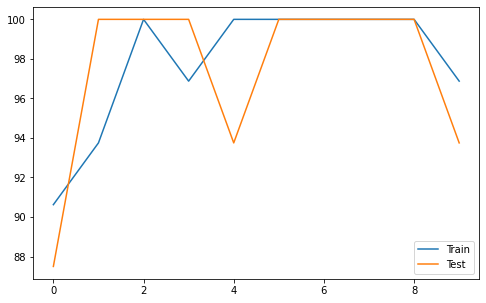

The Accuracy on train was 96.88, and on test was 93.75.


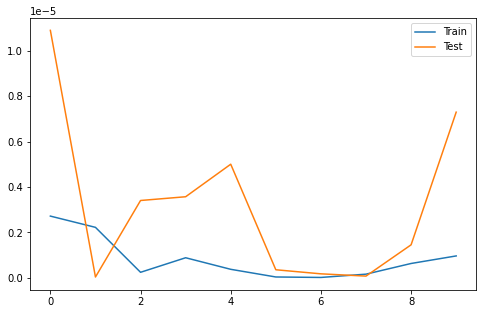

The Losses on train was 0.0, and on test was 0.0.


In [12]:
network_plots(plot_train_accuracy, plot_test_accuracy, 'Accuracy')
network_plots(plot_train_losses, plot_test_losses, 'Losses')

1.0


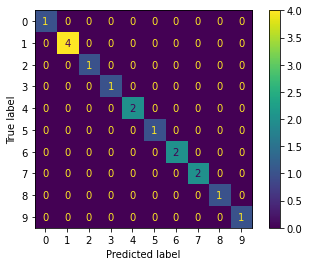

In [14]:
model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device=device)
        y = y.to(device=device)
        outputs = model(x)
        values, predictions = torch.max(outputs, 1)
        y = y.cpu().detach().numpy()
        predictions = predictions.cpu().detach().numpy()
model.train()

conf_matrix = confusion_matrix(
    y_true = y,
    y_pred = predictions
    )
labels = np.unique(y)

print(accuracy_score(y, predictions))


plot_cm = ConfusionMatrixDisplay(
    confusion_matrix = conf_matrix,
    display_labels = labels
    ) \
    .plot()

plt.show()